# Implement Grover's search algorithm in Qibo

*Author*: Júlia Barberà, March 10th 2022

In this notebook I will try to apply Grover's algorithm to find the factors of a number. As we know, Grover's algorithm finds elements from a unordered list so we will use it to find the divisors of a given decimal number. I want to find the factors of a number $M$ using Grover's algorithm so the steps I will follow are the next ones:

1. Create the circuit with the number of qubits corresponding to the bit size of the number M. Then, I will superpose all states that can be made by using that number of qubits.

2. Apply the Grover's oracle which will change the sign of all states that can factorise M. 


2. Implement Grover's diffusion operator in order to amplificate these solution states. 


3. Execute the circuit and plot what it's been measured. Factor numbers will have more probability than the ones that aren't solution.  

In [2]:
# Import all libraries that I will use
import numpy as np
import math as m
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time 

### Binary to decimal function

This function takes as input the integer I need to convert it to binary number.  
First, it uses an integrated python function to convert the number into a binary string and then it removes first two digits "0b".

In [3]:
def dec_to_binary(x):
    s = bin(x)
    s1 = s[2:] #removes "0b"
    return s1

The following function generates a list with dimension = $nqubits$ of the binary digits of a decimal number. 

In [4]:
def bin_list(dec,nqubits): 
    binary = format(dec,'0{}b'.format(nqubits))
    return list(map(int, str(binary)))

### Multi-controlled Z gate 

The CZ gate is used to invert the phase of the state $|11...1\rangle$. To make it easier we can express the CZ gate in terms of other quantum logic gates: $Z = H X H$. 
So the MCZ of the circuit will have the following transformation: 

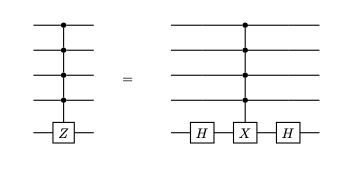

It takes the target (q0) and the number of qubits as an input and returns the circuit after applying the MCZ gate.
We will use this gate for the Oracle and the Diffusion operator. 

In [5]:
def MCZ(q0,nqubits): # defining multi-controlled Z function 
    c.add(gates.H(q0))
    c.add(gates.X(q0).controlled_by(*range(1,nqubits)))
    c.add(gates.H(q0))
    return c 

### Quantum operation to check if a number is a divisor: $U_w$

The Grover's oracle generates a reflection to the state we want to find. Imagine we have the following superposition ($nqubits = 2$): $|s\rangle = \frac{1}{\sqrt{2}} (|00 \rangle +|01 \rangle +|10 \rangle +|11 \rangle) $ and I want to find the state $|10 \rangle$. When I apply the oracle to the initial state it will turn into: <center> $U_w|s\rangle = \frac{1}{\sqrt{2}} (|00 \rangle +|01 \rangle -|10 \rangle +|11 \rangle) $ 
    
We can recognize that the CZ quantum gate is the one that performs this operation. But firstly, I will create a classical diagonal matrix filled with ones on the diagonal except the position that corresponds to states which are solution of the problem, they will have the value -1 in order to flip the state.  The function proceeds in this way: 

It takes the bit size of the dividend and a list of all states (numbers that are solution of the problem) as the input. 

1. Creates an square matrix filled with 0 with the number of qubits as the size of it. It also generates a list of all states available considering the number of qubits. 

2. At the diagonal position that corresponds to the factor divisor, adds a -1 and removes this state from the list that contains all of them. 

3. Using the states list, the ones that remain are the ones that aren't solution of the problem so it adds a +1 at their diagonal position. 

The function returns the circuit after applying the matrix to all qubits. 

In [6]:
def Mark_Divisor_matrix(bit_size, divisor):
    
    inv_matrix = np.zeros( (2**bit_size, 2**bit_size) ) #empty matrix 
    states = list(range(2**bit_size))
    
    for div in divisor:
        inv_matrix[div][div] = -1 #add a -1 in order to flip the state
        states.remove(div)
        
    for el in states:
        inv_matrix[el][el] = 1 
    
    return c.add(gates.Unitary(inv_matrix,*range(0,bit_size)))

The matrix that we need has de following shape diag{1,-1,-1,1,-1,1,1,1,1} if we want to factorise, for example, number 4. It has to have the diagonal filled with ones and a -1 at the position of divisors.

As previously mentioned, there must be a way to accomplish this reflection using quantum gates. One can tell intuitively that X quantum gate and Z gate will be the ones performing this operation. These one-single-qubit gates correspond to following matrices: 

<br>

<center> $X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}$, $Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$ </center>
    
<br>
    
Firstly, the X gate will be used to move the state that needs to be find to the last diagonal position. Once this has been achieved, Z gate (or CZ or MCZ in case the circuit has more than 1 qubit) will be add to the circuit in order to flip the state located at the last diagonal entry. At the end, we will have to invert states' order by applying the same procedure we did to move them: using X gate.
    
In conclusion, this function takes as input the dimension of the hilbert subspace and a list with divisors of a number. The next steps are described below:  
    
1.Checks if any factor included in the input list corresponds to the last state that can be made with $2^{nqubits}$. If that's the case, there's no need to apply X gates as we already have the state in the position we want. The MCZ gate is applied with $range(nqubits - 1)$ as control qubits and $(nqubits - 1)$ the target in order to flip the state. 
    
2.If the factor is not the last state, X gates have to be applied in order to move the state. 
    
- The first thing we will do is create a list of ones with dimension = $nqubits$ equivalent to the last binary state.We will use this list to compare the binary digits between this state and the factor. 
- Then, X gates will be applied to move the state. If the first qubit of the final state is not equal to the factor's first digit, the X gate will be applied to that qubit as it transforms $|0\rangle$ to $|1\rangle$ and the other way around. We will do that procedure for all the qubits that compose the state. 
- MCZ will be add after the previous step and will flip the factor's state.
- We will invert states' position in order to have them in the way we had at the begining. We will use X gates to do so. 

In [7]:
def Mark_Divisor(nqubits,state):
    
    for s in state:
        if state == (2**nqubits -1) :
            c.add(gates.Z(nqubits - 1).controlled_by(*range(nqubits - 1)))
        else:
            final_st = np.ones((nqubits,), dtype=int) #last state available
            binary = bin_list(s,nqubits) #decimal to binary integer list
            
            for i in range(len(final_st)): # Moving "state" to the last diagonal position
                if (binary[i] != final_st[i]):
                    c.add(gates.X(i))  
                
            c.add(gates.Z(nqubits - 1).controlled_by(*range(nqubits - 1))) 
        
            for i in range(len(final_st)): 
                if (binary[i] != final_st[i]):
                    c.add(gates.X(i))

### Grover's diffusion operator: $U_s$

This operator, expressed like: $U_s = 2|s\rangle \langle s | - I$,  will be applied after the Oracle, and will perform an extra reflection to the state $U_w |s\rangle$. It will aplificate the state we want to find, making it have a much greater probability than the other ones. The Diffusion operator will have the following universal form : 

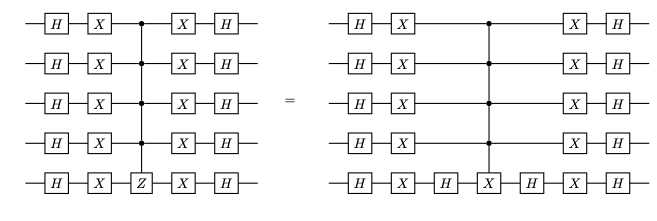

The hadamard gates will create a superposition of all states. Then, the X gate performs a qubit-flip (it is the equivalent to the NOT classical gate) so it makes a rotation by π radians around the x-axis of the Bloch sphere. When we have the states fliped...

In [8]:
def diffusion(q0,nqubits): 

    c.add([gates.H(i) for i in range(nqubits)])    
    c.add([gates.X(i) for i in range(nqubits)])
    MCZ(q0,nqubits) #q0 is the target and the other ones, control qubits
    c.add([gates.X(i) for i in range(nqubits)])
    c.add([gates.H(i) for i in range(nqubits)])
    
    return c

### Main code

The code follows the next procedure to find factors of a given number: 
    
1. Asks the number you want to find: the dividend and ccomputes the bit size of this number.

2. Divides the dividend by all numbers which are candidates to be a factor of it. This means that, if the remainder is equal to 0 we will save the number (state) in a list and if it's not we won't do anything. I will leave 0 number out of the list as it's never a factor of any number and in order to avoid divergences. 

3. Calculates R corresponding to repetitions of the Grover's iterator. The more times we apply the oracle, the higher probability we will get. (demonstration of the following equation will be shown here) 
<br>

<center> $R = \frac{\pi}{4}\cdot \sqrt{\frac{N}{M}}$ </center>

<br>

3. Starts a loop where it will run the full Grover's algorithm for each R by applying the Grover's iterator.

4. Executes the circuit in order to find the resulta and draws the circuit. 

In [9]:
dividend = int(input("Which number do you want to factorize? "))
bit_size = len(dec_to_binary(dividend)) #Converts decimal number into binary and calculates bit size 
factors = [ ]
max_probs = { }
print()

#Finds factors of M (with remainder 0)
divisors = range(1,2**bit_size) # left 0 out of the list
for div in divisors:
    if (dividend % div) == 0:
        factors.append(div)

N_opt = round((np.pi/4)*np.sqrt(2**bit_size)/len(factors)) 
print("Optimal times to apply the oracle = ", N_opt)
print()

for i in range(1,N_opt+1):
    
    c = Circuit(bit_size) # Constructs the circuit (2 qubits)
    c.add([gates.H(i) for i in range(bit_size)])

    for j in range(i):
        Mark_Divisor(bit_size, factors)
        diffusion(0,bit_size)
         
    # Executes the circuit and obtain the final state
    result = c()
    y = result.state(numpy=True)
    prob = [ ]
    for el in factors:
        prob.append(y[el].real*y[el].real)
        
    max_probs[str(i)] = prob

# Draws the circuit
print(c.draw())
print()
for el in factors:
    print("The number", el, "is a factor of", dividend)

Which number do you want to factorize? 13

Optimal times to apply the oracle =  2

q0: ─H─X─o─X───o─H─X─H─X─H─X─H─X─o─X───o─H─X─H─X─H─X─H─
q1: ─H─X─o─X───o─H─X───o─X─H─X───o─X───o─H─X───o─X─H───
q2: ─H─X─o─X─X─o─X─H─X─o─X─H─X───o─X─X─o─X─H─X─o─X─H───
q3: ─H───Z─────Z─H─X───o─X─H─────Z─────Z─H─X───o─X─H───

The number 1 is a factor of 13
The number 13 is a factor of 13


### Plots

This plot will show from all states available (created by nqubits), the ones with more probability which correspond to solutions of the problem. These numbers (or states) will be the factors of the dividend I have given. 

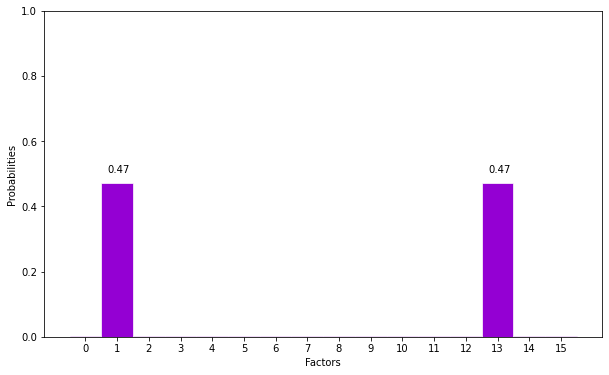

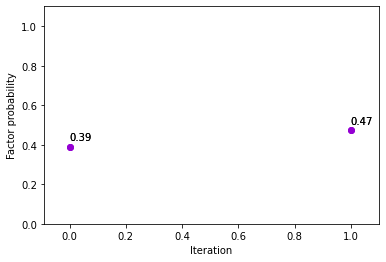

In [10]:
# FINDING STATE 
x = range(2**bit_size)
prob = [x.real*x.real for x in y] # elevating coeficients = probability 

fig, ax = plt.subplots()
ax.bar(x, prob, width=1, edgecolor="white",color = "darkviolet", linewidth=0.7)
ax.set(ylim=(0, 1), xlabel = "Factors", ylabel = 'Probabilities')
plt.xticks(x)
plt.gcf().set_size_inches(10, 6) # changes plot size

for el in factors: 
    ax.text(el - 0.3, prob[el]+ 0.03, str(round(prob[el],2)), fontsize=10) #Writes probability

plt.show()

# MAX. PROBABILIY 
oracle_times = range(N_opt)
for i in range(len(oracle_times)):
    for j in range (len(max_probs[str(i+1)])):
        el = max_probs[str(i+1)][j]
        plt.plot(oracle_times[i], el ,'o', color = "darkviolet")
        plt.text(oracle_times[i], el + 0.03, str(round(el.real, 2)), fontsize=10) #Writes probability
    
plt.xlim([0 -0.09 ,N_opt -0.9])
plt.ylim([0,1.1])
plt.xlabel('Iteration')
plt.ylabel('Factor probability') 
    
plt.show()